# Visualization of groundtruth and estimated poses

> [!IMPORTANT]
> Prior to executing this notebook, please download and extract the [demo_sample.zip archive](https://drive.google.com/file/d/1odIWNVxUPVrX2eaE6XSoQJOwqYpwD079/view?usp=sharing) to this directory.

This notebook demonstrates how to visualize groundtruth and estimated object poses on images from a BOP dataset.

For a full visualization pipeline, please refer to `vis_poses.py`.

A sample visual containing plots with a depth difference heatmap, object contours, and 3D bounding boxes is depicted below:

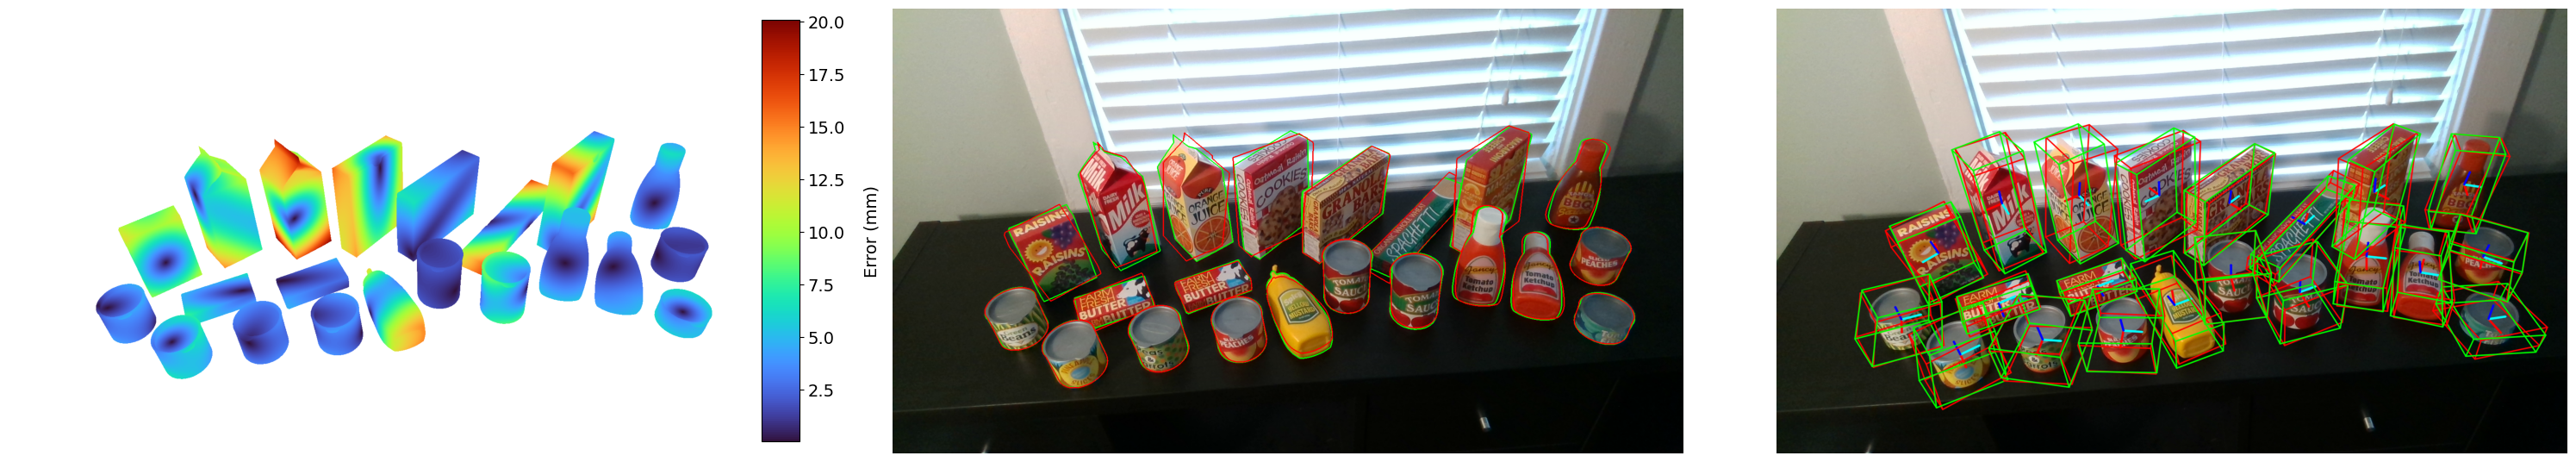

The green color denotes groundtruth poses, while the red color denotes estimates.


In [ ]:
import argparse
import copy
import logging
import trimesh
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json

In [ ]:
from bop_toolkit_lib import inout, misc, visualization
from bop_toolkit_lib.rendering import renderer
from bop_toolkit_lib.common_utils import adjust_img_for_plt
from bop_toolkit_lib.vis_utils import draw_pose_on_img, get_depth_map_and_obj_masks_from_renderings, draw_pose_contour, get_pose_mat_from_dict, calc_mask_visib_percent

                mandatory if you are running evaluation on HOT3d.
                Refer to the README.md for installation instructions.
                


In [ ]:
logger = misc.get_logger("demo")
logger.setLevel(logging.INFO)

args = argparse.Namespace(
    **{
        "renderer_type": "vispy",
        "vis_depth_diff": True,
        "vis_orig_color": False,
        "vis_per_obj_id": False,
        "vis_rgb": True,
        "vis_rgb_resolve_visib": True,
    }
)

In [ ]:
renderer_modalities = []
if args.vis_rgb:
    renderer_modalities.append("rgb")
if args.vis_depth_diff or (args.vis_rgb and args.vis_rgb_resolve_visib):
    renderer_modalities.append("depth")
renderer_mode = "+".join(renderer_modalities)

dp_model = json.load(open("./demo_sample/dp_model.json", "r"))
dp_split = json.load(open("./demo_sample/dp_split.json", "r"))

models = {}
for obj_id in dp_model["obj_ids"]:
    models[obj_id] = inout.load_ply(dp_model["model_tpath"].format(obj_id=obj_id))
models_info = inout.load_json(dp_model["models_info_path"], keys_to_int=True)

In [7]:
width, height = dp_split["im_size"]
logger.info(f"Creating renderer of type {args.renderer_type}")
ren = renderer.create_renderer(
    width,
    height,
    args.renderer_type,
    mode=renderer_mode,
    shading="flat",
)
logging.getLogger("vispy").setLevel(logging.ERROR)
# Load object models in the new renderer.
for obj_id in dp_model["obj_ids"]:
    model_path = dp_model["model_tpath"].format(obj_id=obj_id)
    ren.add_object(obj_id, model_path)

# Load saved data
rgb = inout.load_im("./demo_sample/rgb.png")
depth = inout.load_im("./demo_sample/depth.png")
pose_data = np.load("./demo_sample/pose_data.npz", allow_pickle=True)
cam = pose_data["cam"]
gt_poses = pose_data["gt_poses"]
est_poses = pose_data["est_poses"]

res = visualization.vis_object_poses(
    poses=est_poses,
    K=cam,
    renderer=ren,
    rgb=rgb,
    depth=depth,
    vis_rgb=args.vis_rgb,
    vis_depth_diff=args.vis_depth_diff,
    vis_rgb_resolve_visib=args.vis_rgb_resolve_visib,
)
res_gt = visualization.vis_object_poses(
    poses=gt_poses,
    K=cam,
    renderer=ren,
    rgb=rgb,
    depth=depth,
    vis_rgb=args.vis_rgb,
    vis_depth_diff=args.vis_depth_diff,
    vis_rgb_resolve_visib=args.vis_rgb_resolve_visib,
)

INFO:demo:Creating renderer of type vispy


vispy uses app: egl, gl: gl2


/home/master/.conda/envs/bop/lib/python3.10/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


depth_diff:   0%|          | 0/21 [00:00<?, ?it/s]

contour:   0%|          | 0/21 [00:00<?, ?it/s]

bbox:   0%|          | 0/21 [00:00<?, ?it/s]

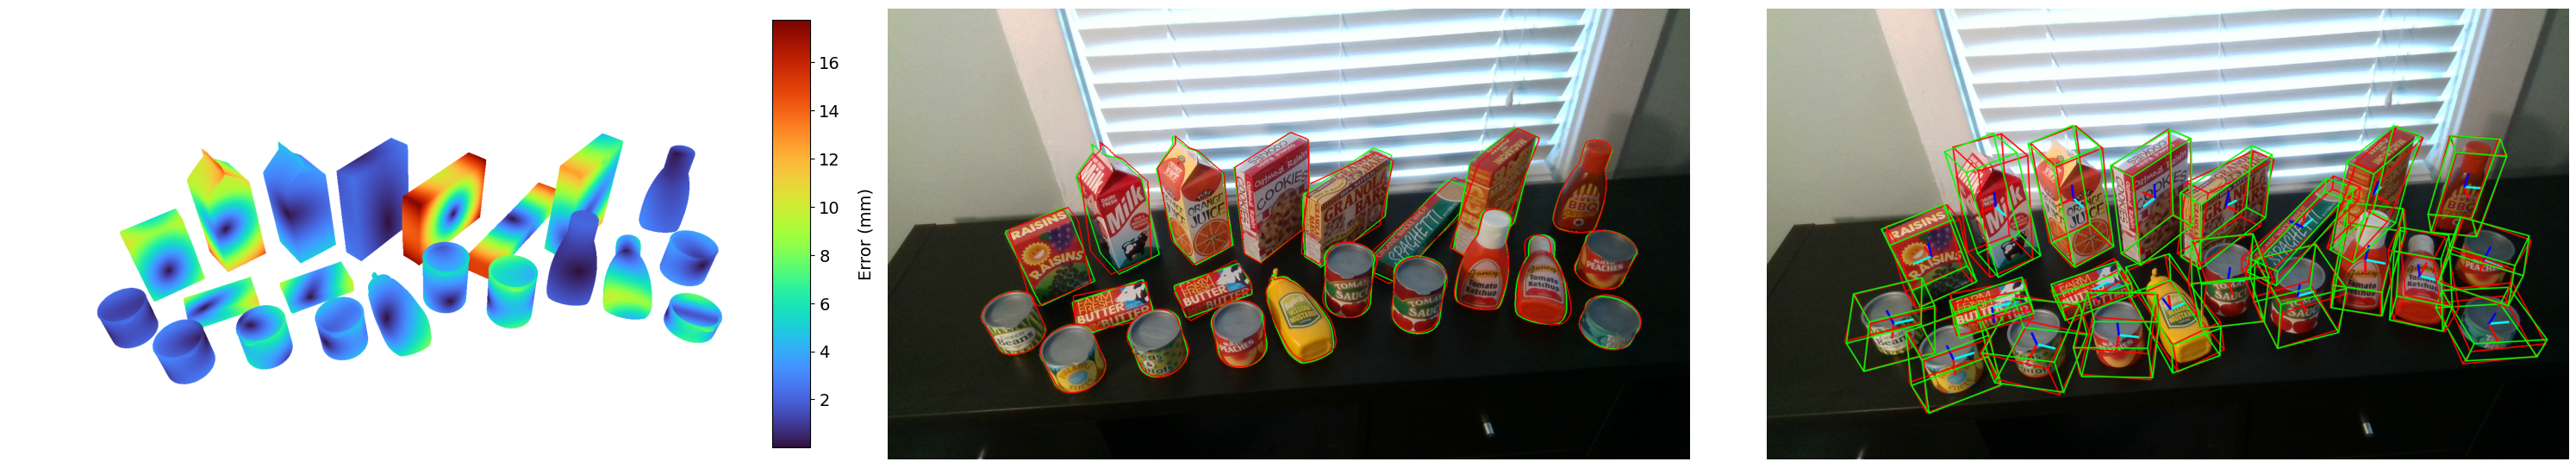

In [ ]:
from bop_toolkit_lib.vis_utils import combine_depth_diffs, get_depth_diff_img, merge_masks, plot_depth


def plot_rgb(rgb, ax=None, num_cols=1, figsize=(10, 5)):
    if ax is None:
        fig, ax = plt.subplots(1, num_cols, figsize=figsize)
        ax.axis("off")
    res = adjust_img_for_plt(rgb)
    ax.imshow(res)
    return ax


res_per_obj_gt = res_gt["res_per_obj"]
res_per_obj = res["res_per_obj"]

bres = get_depth_map_and_obj_masks_from_renderings(res_per_obj)
bres_gt = get_depth_map_and_obj_masks_from_renderings(res_per_obj_gt)
depth_map = bres["depth_map"]
mask_objs = bres["mask_objs"]
depth_map_gt = bres_gt["depth_map"]
mask_objs_gt = bres_gt["mask_objs"]
gt_poses_ordered = [v["pose"] for oidx, v in res_per_obj_gt.items()]

depth_diff_meshs = []
gt_depths = []
rgbs = []
gt_rgbs = []
for obj_idx in tqdm(res_per_obj_gt.keys(), desc="depth_diff"):
    obj_res = res_per_obj[obj_idx]
    est_depth = obj_res["depth"]
    gt_depth = res_per_obj_gt[obj_idx]["depth"]
    gt_obj_res = res_per_obj_gt[obj_idx]
    obj_id = gt_obj_res["pose"]["obj_id"]
    sym_mat = misc.get_symmetry_transformations(models_info[obj_id], 0.01)
    model = models[obj_id]
    pts = model["pts"]
    pose = obj_res["pose"]
    rgbs.append(obj_res["rgb"])
    gt_rgbs.append(gt_obj_res["rgb"])
    depth_diff_mesh = get_depth_diff_img(
        gt_depth=gt_depth,
        est_pose=pose,
        gt_pose=gt_obj_res["pose"],
        cam=cam,
        syms=sym_mat,
    )
    depth_diff_meshs.append(depth_diff_mesh)
    gt_depths.append(gt_depth)

dres = combine_depth_diffs(
    mask_objs_gt,
    depth_diff_meshs,
    use_clip=False
)
depth_diff_img = dres["combined"]
imgs = dres["imgs"]

mask_objs_gt_merged = merge_masks(mask_objs_gt)
fig, axs = plt.subplots(1, 3, figsize=(30, 15))
plot_depth(
    depth_diff_img,
    cbar_title="Error (mm)",
    ax=axs[0],
    cmap="turbo",
    use_horiz_cbar=False,
    use_white_bg=True,
    include_colorbar=True,
    use_fixed_cbar=True,
    mask=mask_objs_gt_merged,
    rgb=None,
    vmax=None,
)

contour_img = copy.deepcopy(rgb)
for idx, gt_pose_ in enumerate(tqdm(gt_poses_ordered[:], desc="contour")):
    gt_pose_mat = get_pose_mat_from_dict(res_per_obj_gt[idx]["pose"])
    mesh = trimesh.Trimesh(
        vertices=models[gt_pose_["obj_id"]]["pts"],
        faces=models[gt_pose_["obj_id"]]["faces"],
    )
    depth_obj_gt = res_per_obj_gt[idx]["depth"]
    depth_obj = res_per_obj[idx]["depth"]
    depth_obj_mask = depth_obj_gt > 0
    mask_obj = mask_objs[idx]
    mask_obj_gt = mask_objs_gt[idx]

    percent = calc_mask_visib_percent(mask_obj, depth_obj_mask)
    if percent < 20:
        print(f"{idx=} {percent=}")
        continue

    contour_img = draw_pose_contour(
        contour_img,
        rendered_depth=depth_obj_gt,
        mask_visib=mask_obj_gt,
        contour_color=(0, 255, 0),
    )
    est_pose_mat = get_pose_mat_from_dict(res_per_obj[idx]["pose"])
    contour_img = draw_pose_contour(
        contour_img,
        rendered_depth=depth_obj,
        contour_color=(255, 0, 0),
        mask_visib=mask_obj,
    )
plot_rgb(contour_img, ax=axs[1])

bbox_img = copy.deepcopy(rgb)
for idx, gt_pose_ in enumerate(tqdm(gt_poses_ordered, desc="bbox")):

    obj_id = res_per_obj_gt[idx]["pose"]["obj_id"]
    pose_gt = res_per_obj_gt[idx]["pose"]
    pose_est = res_per_obj[idx]["pose"]
    model = models[obj_id]
    pts = model["pts"]
    mesh = trimesh.Trimesh(vertices=pts, faces=model["faces"])
    bbox_3d = trimesh.bounds.corners(mesh.bounding_box_oriented.bounds)
    depth_obj_gt = res_per_obj_gt[idx]["depth"]
    depth_obj_mask = depth_obj_gt > 0
    mask_obj = mask_objs[idx]
    percent = calc_mask_visib_percent(mask_obj, depth_obj_mask)
    if percent < 35:
        print(f"{idx=} {percent=}")
        continue

    syms = misc.get_symmetry_transformations(
        models_info[obj_id], max_sym_disc_step=0.01
    )
    pts_est = misc.transform_pts_Rt(pts, pose_est["R"], pose_est["t"].squeeze())
    gt_poses_syms = []
    es = []
    for sym in syms:
        R_gt_sym = pose_gt["R"].dot(sym["R"])
        t_gt_sym = pose_gt["R"].dot(sym["t"].squeeze()) + pose_gt["t"].squeeze()
        pts_gt_sym = misc.transform_pts_Rt(pts, R_gt_sym, t_gt_sym)
        gt_poses_syms.append({"R": R_gt_sym, "t": t_gt_sym, "obj_id": obj_id})
        es.append(np.linalg.norm(pts_est - pts_gt_sym, axis=1).max())
    best_idx = np.argmin(es)
    pose_gt_sym = gt_poses_syms[best_idx]
    pose_gt_sym_mat = get_pose_mat_from_dict(pose_gt_sym)

    est_pose_mat = get_pose_mat_from_dict(res_per_obj[idx]["pose"])
    bbox_img = draw_pose_on_img(
        bbox_img,
        pose_pred=est_pose_mat,
        pose_gt=pose_gt_sym_mat,
        K=cam,
        axes_scale=50 // 2,
        mesh_bbox=bbox_3d,
        bbox_color=(255, 0, 0),
        bbox_color_gt=(0, 255, 0),
    )

plot_rgb(bbox_img, ax=axs[2])
for ax in axs:
    ax.axis("off")
plt.tight_layout()